## Álvaro Huertas García

In this notebook we Deep Learning to classify documents from 5 categories (Alzheimer, Bladder Cancer, Cervical Cancer, Breast Cancer and Negative.)

Here we use ScispaCy pre-trained embeddings. 

**VERY IMPORTANT** $\rightarrow$ It is adapted from: https://medium.com/@armandj.olivares/a-basic-nlp-tutorial-for-news-multiclass-categorization-82afa6d46aa5

## Load the data

In [0]:
COLAB = True

if COLAB:
    import urllib
    # Data
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1zJuh8XJTf_5hPZ8jVEUtGW1BnBZ6Yy4z",
                              "precision_medicine.zip")
    # Long stop word
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1PcVSBLgIpJVXAj4JD8_EQAGprte4zuyn",
                              "long_stop_words.txt")
    # Clinical stop words
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1M5a92cvQ3L7okuYHBuZh2K1f_MsrupuF",
                              "clinical_stop_words.txt")

In [0]:
f = open("long_stop_words.txt", "+r")
long_stopwords = f.read().split("\n")
len(long_stopwords)

853

In [0]:
f = open("clinical_stop_words.txt", "+r")
clinical_stopwords = f.read().split("\n")
len(clinical_stopwords)

811

In [0]:
!unzip precision_medicine.zip 

Archive:  precision_medicine.zip
   creating: precision_medicine/
  inflating: precision_medicine/Alzheimer_abstracts.tsv  
   creating: __MACOSX/
   creating: __MACOSX/precision_medicine/
  inflating: __MACOSX/precision_medicine/._Alzheimer_abstracts.tsv  
  inflating: precision_medicine/Bladder_Cancer_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._Bladder_Cancer_abstracts.tsv  
  inflating: precision_medicine/Breast_Cancer_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._Breast_Cancer_abstracts.tsv  
  inflating: precision_medicine/Cervical_Cancer_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._Cervical_Cancer_abstracts.tsv  
  inflating: precision_medicine/negative_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._negative_abstracts.tsv  
  inflating: __MACOSX/._precision_medicine  


In [0]:
files = [('Alzheimer_abstracts.tsv', 'Alzheimer'),
         ('Bladder_Cancer_abstracts.tsv', 'Bladder Cancer'),
         ('Breast_Cancer_abstracts.tsv', 'Breast Cancer'),
         ('Cervical_Cancer_abstracts.tsv', 'Cervical Cancer'),
         ('negative_abstracts.tsv', 'Negative'),]

input_folder = './precision_medicine/'

In [0]:
def load_file(file_name):
    with open(file_name) as f:
        examples = []
        content = f.readlines()
        for l in content:
            aux = l.split('\t')
            examples.append((aux[0], (' '.join(aux[1:])).replace('\n', ' ')))
        return examples

In [0]:
import numpy as np

# Variables donde almacenamos cada texto y su etiqueta
narratives = []
labels = []

# Para cada uno de los 5 archivos extraemos sus textos y le asignamos la etiqueta
for f,label in files:
    aux = load_file(input_folder + f)
    narratives.extend([x[1] for x in aux])
    labels.extend(len(aux)*[label])

labels = np.array(labels)

len(narratives), len(labels)

(5000, 5000)

In [0]:
def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

def visualiza_procesamiento_LSTM(seq, y, text, interpretacion_sentimientos, model2, alpha=0.2):
    plt.figure(figsize=(15,15))

    plt.plot(sals_finales_pca_tr[inds_0,0],
             sals_finales_pca_tr[inds_0,1], '.', alpha=alpha/2)
    plt.plot(sals_finales_pca_tr[inds_0[-1],0],
             sals_finales_pca_tr[inds_0[-1],1], '.', c = "red", 
             label=interpretacion_sentimientos[0])
    
    plt.plot(sals_finales_pca_tr[inds_1,0],
             sals_finales_pca_tr[inds_1,1], '.',  alpha=alpha)
    plt.plot(sals_finales_pca_tr[inds_1[-1],0],
             sals_finales_pca_tr[inds_1[-1],1], '.', c = "blue",
             label= interpretacion_sentimientos[1])
    
    plt.plot(sals_finales_pca_tr[inds_2,0],
             sals_finales_pca_tr[inds_2,1], '.',  alpha=alpha)
    plt.plot(sals_finales_pca_tr[inds_2[-1],0],
             sals_finales_pca_tr[inds_2[-1],1], '.', c = "green", 
             label=interpretacion_sentimientos[2])

    plt.plot(sals_finales_pca_tr[inds_3,0],
             sals_finales_pca_tr[inds_3,1], '.', alpha=alpha)
    plt.plot(sals_finales_pca_tr[inds_3[-1],0],
             sals_finales_pca_tr[inds_3[-1],1], '.', c = "orange", 
             label=interpretacion_sentimientos[3])
    
    plt.plot(sals_finales_pca_tr[inds_4,0],
             sals_finales_pca_tr[inds_4,1], '.',  alpha=alpha)
    plt.plot(sals_finales_pca_tr[inds_4[-1],0],
             sals_finales_pca_tr[inds_4[-1],1], '.', c = "purple",
             label=interpretacion_sentimientos[4])

    text_aux = [int2word[x] for x in seq]
    aux = pca.transform(model2.predict(np.array([seq]))[0])
    plt.plot(aux[:,0], aux[:,1])
    for x,w in zip(aux,text_aux):
        plt.text(x[0],x[1],w)
    plt.plot(aux[0,0],aux[0,1],'og',markersize=40,alpha=0.5)
    plt.plot(aux[0,0],aux[0,1],'og',label="Start")
    plt.plot(aux[-1,0],aux[-1,1],'oy',markersize=40,alpha=0.5)
    plt.plot(aux[-1,0],aux[-1,1],'oy',label="End")
    # plt.title("{} \n Sentimiento={} ({})".format(text, y,interpretacion_sentimientos[y]), fontsize=16)
    plt.legend(fontsize=24);

## Transform data to pandas

In [0]:
import pandas as pd
df_biomedic = pd.DataFrame()
df_biomedic["narratives"] = narratives
df_biomedic["labels"] = labels
df_biomedic

,narratives,labels
0,How the cognitive reserve interacts with beta-...,Alzheimer
1,Negative Bias in the Perception and Memory of ...,Alzheimer
2,Anosognosia and Its Relation to Psychiatric Sy...,Alzheimer
3,Family history and APOE4 risk for Alzheimer's ...,Alzheimer
4,Data-driven regions of interest for longitudin...,Alzheimer
...,...,...
4995,Universal Coverage without Universal Access: I...,Negative
4996,Decreased use of glucocorticoids in biological...,Negative
4997,Evaluating the Utility of Single-Locus DNA Bar...,Negative
4998,Convection-driven kinematic dynamos at low Ros...,Negative


# Pipeline

The data input will pass through a word embedding layer, a word embedding is a form of representing words and documents using a dense vector representation, so we need build the embedding using the following:

* Use tokenizer methods from the vectorizer tf-idf step
* make a vocabulary (limited to a number of words)
* make the text to sequence to convert words to numbers
* Load the pretrained word embeddings
* build the vector embedding with spacy



In [0]:
!pip install Unidecode

     |████████████████████████████████| 245kB 4.7MB/s 


In [0]:
import unidecode
import re
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt


from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG, clear_output
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Embedding
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm # pip install tqdm
pd.options.mode.chained_assignment = None
import collections
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool, LabelSet, ColumnDataSource, Range1d
from bokeh.plotting import figure, show, output_notebook
from IPython.display import SVG, clear_output
from keras.utils.vis_utils import model_to_dot
import pickle
import sys
from string import punctuation

# fix random seed for reproducibility
np.random.seed(7)

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


# Pre-processing

In [0]:
def pprocessor_no_delete_stop(text):
  '''Pre-process text for extract bigrams'''

  # Text to unicode
  text = unidecode.unidecode(text)

  # Remove introduction words for sections
  text = re.sub("[A-Z]{0,}\s[A-Z]+:", "", text) 

  # Lowercase and remove extra spaces
  text = text.strip().lower()

  # E mail
  text = re.sub(r"e\s?-\s?mail", "email", text)

  # Substitute p value
  text = re.sub('p\s?[<=]\s?0?[.,]0[0-5]+', 'hppv', text) # Significant
  text = re.sub('p\s?[>=]\s?[\d]+[.,]?\d*', 'lppv', text) # Non-significant

  # Punctuation
  punctuation_marks = set(punctuation)
  punctuation_marks.update(chr(177))

  for i in punctuation_marks:
    element = "\\"+i # scape the character
    sub_element = " "+i+" " # Example "=" --> " = "
    text = re.sub(element, sub_element, text)

  
  # Substitute irrelevant (isolated) numbers by NUM
  text = re.sub( '[^A-Za-z][\-~]?[0-9][0-9]*\s?[.,]?\s?[0-9]+[^A-Za-z]', " num ", text)
  text = re.sub( "\s[0-9]+\s", " num ", text)

  # Double to single space
  text = re.sub(r"\s{2,}", " ", text)

  return text

In [0]:
def pprocessor_delete_stop(text, stoptext = "long", lemmatizer = "nltk"):
  sys.stdout.write('.')
  sys.stdout.flush()


  # Text to unicode
  text = unidecode.unidecode(text)

  # Remove introduction words for sections
  text = re.sub("[A-Z]{0,}\s[A-Z]+:", "", text) 

  # Lowercase and remove extra spaces
  text = text.strip().lower()

  # E mail
  text = re.sub(r"e\s?-\s?mail", "email", text)

  # Substitute p value
  text = re.sub('p\s?[<=]\s?0?[.,]0[0-5]+', 'hppv', text) # Significant
  text = re.sub('p\s?[>=]\s?[\d]+[.,]?\d*', 'lppv', text) # Non-significant

  # Separate punctation to replace numbers for NUM better
  from string import punctuation
  punctuation_marks = set(punctuation)
  punctuation_marks.update(chr(177))

  for i in punctuation_marks:
    element = "\\"+i # scape the character
    sub_element = " "+i+" " # Example "=" --> " = "
    text = re.sub(element, sub_element, text)


  # Substitute irrelevant (isolated) numbers by NUM
  text = re.sub( '[^A-Za-z][\-~]?[0-9][0-9]*\s?[.,]?\s?[0-9]+[^A-Za-z]', " num ", text)
  text = re.sub( "\s[0-9]+\s", " num ", text)

  # Tokenize the text
  tokenized_text = nltk.word_tokenize(text)

  

  # Delete Punctuation
  tokenized_text = [i for i in tokenized_text if i not in punctuation_marks]


    # Delete stop words
  if stoptext == "spacy":
    spacy_nlp = spacy.load('en_core_web_sm')
    spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    stop_words = sorted(spacy_stopwords)

  if stoptext == "nltk":
    nltk_stopwords = nltk.corpus.stopwords.words('english')
    stop_words = sorted(nltk_stopwords)

  if stoptext == "clinical":
    stop_words = clinical_stopwords

  if stoptext == "long":
    stop_words = sorted(long_stopwords)

  tokenized_text = [i for i in tokenized_text if i not in stop_words]


  # Lemmanization
  if lemmatizer == "nltk":
    lemmatizer = WordNetLemmatizer().lemmatize
    lemmatized_text = [lemmatizer(word) for word in tokenized_text]

  
  if lemmatizer == "spacy":
    nlp = spacy.load('en', disable=['parser', 'ner'])
    doc = nlp(" ".join(tokenized_text))
    lemmatized_text = [token.lemma_ for token in doc]


  # Join all the text  
  full_text = " ".join(lemmatized_text)

  return full_text

# Split the data: train, test, validation

In [0]:
from sklearn.model_selection import train_test_split
import time
X = df_biomedic['narratives']
y =df_biomedic['labels']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
codification = [ (encoder.transform(encoder.classes_)[i], encoder.classes_[i])  for i in range(len(encoder.classes_))]
print(codification)
Y = np_utils.to_categorical(y)

# Split data
seed = 0
x_train, x_test_val, y_train, y_test_val = train_test_split(X, Y, test_size=0.3, random_state=seed, stratify =y)
# Create validation set
x_te, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=seed, stratify =y_test_val)

[(0, 'Alzheimer'), (1, 'Bladder Cancer'), (2, 'Breast Cancer'), (3, 'Cervical Cancer'), (4, 'Negative')]


In [0]:
print(X[0])
print(x_train[0])

How the cognitive reserve interacts with beta-amyloid deposition in mitigating FDG metabolism: An observational study. This observational study had the aim to assess the interaction between cognitive reserve (CR) and cerebrospinal fluid beta-amyloid1-42 (Abeta1-42) in modulating brain [18F]fluorodeoxyglucose positron emission tomography (FDG-PET) metabolism in patients with moderate Alzheimer disease (AD).Twenty-seven patients with probable AD and 25 neurological normal subjects (NNS) entered the study. All participants had an FDG-PET scan, and AD patients also received a lumbar puncture to measure Abeta1-42, 181p-tau, and Tau concentrations. Based on years of formal education, AD patients were classified as highly educated-AD (years of formal education >5) or less educated-AD (years of formal education <5). By using a voxel-wise approach, we first investigated differences in the cerebral glucose uptake between AD and NNS, then we assessed the interaction between level of education (a 

<font color="yellow">Very important. We can decode the labels to see the original label  <font>

In [0]:
# Decode labels

# Train
train_classes = [np.argmax(y, axis=None, out=None) for y in y_train]
train_label = [encoder.classes_[i] for i in train_classes]
print(train_classes)
print(train_label)

# Test
test_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
test_label = [encoder.classes_[i] for i in test_classes]

# Validation
val_classes = [np.argmax(y, axis=None, out=None) for y in y_val]
val_label = [encoder.classes_[i] for i in val_classes]

[3, 1, 4, 4, 1, 1, 0, 0, 2, 1, 3, 0, 4, 1, 0, 3, 0, 3, 4, 1, 1, 4, 3, 1, 3, 0, 2, 2, 4, 0, 4, 0, 4, 3, 4, 4, 0, 4, 2, 3, 1, 1, 3, 0, 1, 4, 0, 1, 3, 4, 1, 1, 2, 1, 1, 2, 1, 2, 0, 4, 2, 2, 2, 4, 3, 2, 1, 2, 1, 3, 4, 1, 3, 2, 4, 4, 2, 3, 0, 4, 1, 1, 0, 0, 0, 1, 1, 4, 3, 1, 0, 3, 1, 3, 0, 0, 2, 1, 1, 2, 4, 0, 3, 2, 1, 0, 0, 1, 3, 2, 3, 3, 3, 2, 1, 2, 3, 3, 4, 3, 2, 2, 2, 2, 3, 3, 4, 2, 0, 1, 4, 4, 3, 2, 0, 4, 1, 4, 4, 2, 2, 0, 1, 0, 2, 1, 0, 0, 2, 0, 4, 1, 4, 2, 4, 4, 1, 4, 4, 2, 1, 1, 2, 1, 4, 0, 0, 1, 0, 1, 4, 0, 4, 2, 4, 4, 2, 0, 2, 3, 4, 4, 2, 4, 0, 1, 1, 0, 0, 3, 1, 3, 4, 4, 2, 4, 4, 3, 0, 1, 1, 4, 3, 3, 4, 0, 4, 0, 3, 1, 4, 4, 0, 0, 1, 0, 3, 3, 2, 2, 1, 4, 4, 0, 1, 3, 3, 0, 0, 4, 1, 4, 0, 2, 2, 2, 2, 1, 0, 1, 1, 1, 0, 1, 2, 0, 3, 1, 4, 0, 0, 2, 4, 4, 1, 2, 0, 1, 4, 3, 3, 2, 4, 4, 4, 3, 1, 4, 3, 0, 2, 0, 1, 0, 4, 1, 4, 2, 0, 0, 3, 0, 3, 0, 2, 1, 3, 1, 4, 1, 0, 2, 0, 4, 4, 2, 3, 1, 3, 4, 2, 3, 1, 4, 4, 1, 1, 0, 3, 1, 3, 2, 0, 4, 1, 0, 4, 4, 4, 1, 0, 0, 1, 0, 3, 3, 0, 4, 0, 3, 1, 4, 3, 

In [0]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('data_NN.pkl', 'wb') as f:
    pickle.dump([x_train, y_train,  train_classes, train_label, x_te, y_test, test_classes, test_label, x_val, y_val, val_classes, val_label ], f)

# For downloading pickle document
from google.colab import files
files.download("data_NN.pkl")

## From text to sequence

Create the feature extraction vector TF-IDF. The parameters used are the selected one in the Machine Learning approach done before (go to  ML_biomedical notebook in this drive or to the pdf document where all the steps are explained)

In [0]:
from keras.preprocessing.text import Tokenizer
# Size of the vocabulary
top_words = 15000

tokenizer2 = Tokenizer(num_words = top_words,   oov_token = "oov")


# Pre-process text 

################# Deleting stop words ################# 

clean_tr_non_stop = [pprocessor_delete_stop(text) for  text in x_train]
clean_te_non_stop = [pprocessor_delete_stop(text) for  text in x_te]
clean_val_non_stop = [pprocessor_delete_stop(text) for  text in x_val]

# Fit the tokenizer
tokenizer2.fit_on_texts(clean_tr_non_stop)

# Set data to sequence
X_train_seq_non_stop = np.array(tokenizer2.texts_to_sequences(clean_tr_non_stop))
X_test_seq_non_stop = np.array(tokenizer2.texts_to_sequences(clean_te_non_stop))
X_val_seq_non_stop = np.array(tokenizer2.texts_to_sequences(clean_val_non_stop))

#################  Not deleting stop words  ################# 
tokenizer = Tokenizer(num_words = top_words,   oov_token = "oov")


clean_tr = [pprocessor_no_delete_stop(text) for  text in x_train]
clean_te = [pprocessor_no_delete_stop(text) for  text in x_te]
clean_val = [pprocessor_no_delete_stop(text) for  text in x_val]


# Fit the tokenizer
tokenizer.fit_on_texts(clean_tr)

# Set data to sequence
X_train_seq = np.array(tokenizer.texts_to_sequences(clean_tr))
X_test_seq = np.array(tokenizer.texts_to_sequences(clean_te))
X_val_seq = np.array(tokenizer.texts_to_sequences(clean_val))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Here we show the difference of the pre-processing effect. 

In [0]:
example = 2320
print(list(x_train)[example]) # Original
print(clean_tr_non_stop[example]) # Removing stop words
print(clean_tr[example]) # Keeping stop words

Low-dose irradiation promotes proliferation of the human breast cancer MDA-MB-231 cells through accumulation of mutant P53. Low-dose irradiation (LDIR) has been proven to have differential biological effects on normal mammalian somatic cells and cancer cells. Our previous study showed that p53 gene status is a critical factor regulating the effect of LDIR on cancer cells. We investigated the effect of LDIR on the breast cancer cell line MDA-MB-231 that harbors a mutant p53 gene, and the normal breast fibroblast cell line Hs 578Bst. In the present study, we showed that 150 mGy LDIR pormoted growth of MDA-MB-231 cells but not Hs 578Bst cells. Through cell cycle analyses, we found that LDIR accelerated cell cycle into S phase in MDA-MB-231 cells, but did not affect the cell cycle of Hs 578Bst cells. Using western blotting, we demonstrated that the expression of CDK4, CDK6 and cyclin D1 was upregulated in MDA-MB-231 cells after LDIR. Although LDIR increased ataxia-telangiectasia mutated (A

<font color="yellow">Very important. We can create dicctionaries with the codification of each word to sequence and viceversa.  <font>

In [0]:
word2int = tokenizer.word_index
int2word = {v: k for k, v in word2int.items()}
int2word[0] = "pad"
print("Total words:", len(word2int)) # Gives all words not only the ones in the vocabulary
print(word2int)
print(int2word)

Total words: 28506
{'oov': 1, 'the': 2, 'num': 3, 'of': 4, 'and': 5, 'in': 6, 'to': 7, 'a': 8, 'with': 9, 'for': 10, 'was': 11, 'cancer': 12, 'were': 13, 'is': 14, 'patients': 15, 'that': 16, 'as': 17, 'by': 18, 'on': 19, 'this': 20, 'we': 21, 'or': 22, 'from': 23, 'study': 24, 'cells': 25, 'be': 26, 'are': 27, 'breast': 28, 'an': 29, 'cell': 30, 'disease': 31, 'cervical': 32, "'": 33, 'treatment': 34, 'at': 35, 'expression': 36, 'bladder': 37, 's': 38, 'between': 39, 'risk': 40, 'have': 41, 'using': 42, 'these': 43, 'tumor': 44, 'associated': 45, 'analysis': 46, 'hppv': 47, 'ad': 48, 'clinical': 49, 'not': 50, 'which': 51, 'after': 52, 'women': 53, 'high': 54, 'has': 55, 'results': 56, 'studies': 57, 'been': 58, 'group': 59, 'based': 60, 'may': 61, 'used': 62, 'carcinoma': 63, 'significantly': 64, 'data': 65, 'human': 66, 'compared': 67, 'also': 68, 'alzheimer': 69, 'than': 70, 'all': 71, 'our': 72, 'cases': 73, 'showed': 74, 'can': 75, 'had': 76, 'no': 77, 'years': 78, 'survival': 79

In [0]:
import plotly.graph_objects as go
w = tokenizer.word_counts
vocab = sorted(w.items(), key = lambda x: x[1], reverse=True)
ordenado = collections.OrderedDict(vocab)
top_palabras = list(ordenado.items())[:50]
palabras = [i[0] for i in top_palabras]
counts = [i[1] for i in top_palabras]
# (top_palabras)
# vocab = [i[0] for i in vocab]
fig = go.Figure(
    data=[go.Bar(x = palabras, y= counts)],
    layout_title_text="Top 50 words in clean train texts (not removing stop words)",
)

fig.update_layout(
    font=dict(
        size=18,
        color="#7f7f7f"))
fig.show()

## Padding

In [0]:
MAX_SEQ_LENGHT= 500

X_train_seq_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LENGHT, value= 0 ) 
print(X_train_seq_pad[1])

X_test_seq_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LENGHT, value= 0 ) 

X_val_seq_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQ_LENGHT, value= 0 ) 


[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

#  Making the spacy embeding

## Spacy pretained embedding

* #### Non Biomedical embedding: 'en_core_web_lg'

## Scispacy pretained embedding (the one used)

* ### Biomedical embedding: "en_core_sci_lg"
    * A full spaCy pipeline for biomedical data with a larger vocabulary and 600k word vectors.

In [0]:
!python -m spacy download en_core_web_lg
! pip install scispacy

     |████████████████████████████████| 827.9MB 1.3MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=f77c4401c9c91b354a5cdfb7a8286d4a00bad0eb309ace81cb60899cf137b972
  Stored in directory: /tmp/pip-ephem-wheel-cache-leugfr3j/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
     |████████████████████████████████| 3.1MB 5.8MB/s 
     |████████████████████████████████| 13.0MB 262kB/s 
     |████████████████████████████████| 6.2MB 40.5MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 296kB 46.9MB/s 
  Created wheel for scispacy: filename=scispacy-0.2.4-cp36-none-any.whl size=35204 sha256=81c25be5ee5a9917bbbea72808fd605d00445f7f0c872dfcde80db32fc9632df
  Stored in directory: /root/.cache/pip/wheels/36/5e/7c/ba8d6b02f5cfa40735e40ccff

In [0]:
# Scispacy embedding 
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

     |████████████████████████████████| 500.6MB 29kB/s 
  Created wheel for en-core-sci-lg: filename=en_core_sci_lg-0.2.4-cp36-none-any.whl size=501343162 sha256=2fab79c7c9dde7f01949265e68cddfbfb6dd9e2e2b374592a4aff0d8ffa65cea
  Stored in directory: /root/.cache/pip/wheels/ea/ab/e5/fa667519032799529ce6a50944a82d6ae3603819cd07836aa2
Successfully built en-core-sci-lg


In [0]:
import scispacy
import spacy

Load the Scispacy object with the embeddings. 

In [0]:
import en_core_sci_lg
nlp = en_core_sci_lg.load()

First we will set the number of dimension of the embedding. 
<font color="red">Very important. The maximum size of the Scispacy embeddings used is 200. <font>


In [0]:
# Example of Scispacy embedding
print(nlp.vocab["cancer"].vector.shape)
nlp.vocab["cancer"].vector

(200,)


array([ 0.0980648 ,  0.185834  , -0.0423638 , -0.0203493 , -0.00401234,
       -0.241798  , -0.0925171 , -0.0739105 , -0.223544  ,  0.0381756 ,
       -0.111134  , -0.313558  ,  0.319907  , -0.0685112 , -0.151516  ,
       -0.254917  , -0.251086  , -0.114102  ,  0.0947415 ,  0.378802  ,
        0.0930784 , -0.25584   , -0.410557  , -0.135354  ,  0.00361536,
        0.207906  , -0.281135  , -0.176277  ,  0.262653  , -0.0600407 ,
        0.351066  , -0.104591  , -0.306744  ,  0.012213  ,  0.0988461 ,
       -0.0153045 ,  0.0239782 , -0.225797  ,  0.0794104 , -0.0444082 ,
       -0.0593331 , -0.0261087 ,  0.0309343 ,  0.383307  ,  0.210614  ,
        0.208686  , -0.419993  , -0.0270837 , -0.229322  , -0.207185  ,
        0.0183404 , -0.300077  ,  0.0249397 , -0.255271  , -0.20904   ,
       -0.0720863 ,  0.31649   ,  0.352701  ,  0.341221  , -0.299133  ,
        0.044759  , -0.106739  , -0.184971  , -0.0728721 , -0.134454  ,
        0.215629  , -0.111165  , -0.10666   ,  0.125751  , -0.04

We create a matrix with the dimensions: vocabulary size x dimensions.
We fill it with the embeddings from Scispacy 

In [0]:
# Set embedding dimension. Maximum 200. 
EMBEDDINGS_LEN = 200

# Set the initial embedding matrix 
## rows are words of the vocabulary
## columns are dimensions
embeddings_index = np.zeros(( top_words, EMBEDDINGS_LEN)) 


for word, idx in word2int.items():
  try:
        embedding = nlp.vocab[word].vector # acces to the Scispacy embedding
        embeddings_index[idx] = embedding # Fill row with spacy values
  except:
        pass

# Neural Networks

In [0]:
list_result = []

## RNN 1: Simple LSTM

<font color="orange"><h1 align="left">Simple LSTM Model</h1></font>

RNN with LSTM, 200 dimension for each word in the vocabulary. Scispacy embeddings are not tuned, so they are fixed. 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 250, 200)          1700000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1005      
Total params: 2,021,805
Trainable params: 321,805
Non-trainable params: 1,700,000
_________________________________________________________________
None


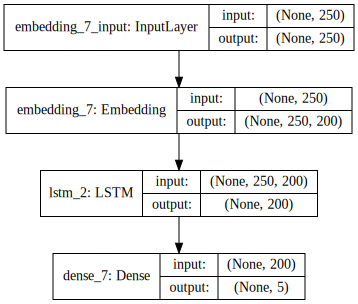

In [0]:
neuron_LSTM = 200 # Number of neurones in the hidden layer
neuron_DENSE = len(set(y)) # Number of neurones in output layer = Number of classes
p = 0.2 # Dropout probability

model = Sequential()
model.add(Embedding(top_words, # Vocabulary size
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))
model.add(LSTM(neuron_LSTM, dropout=p))
# model.add(Dropout(0.2))
model.add(Dense(neuron_DENSE, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #   metrics=[tf.keras.metrics.CategoricalCrossentropy()])

print(model.summary())
SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

In [0]:
from keras.models import load_model
saved_model = load_model('simple_LSTM.h5')

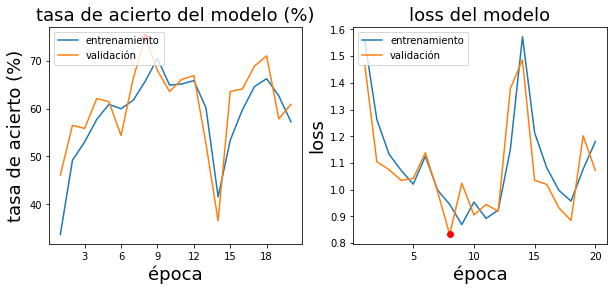

In [0]:
batch_size = 512
nepocas = 20

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [ModelCheckpoint(filepath='simple_LSTM.h5', monitor='val_loss', save_best_only=True)]

for e in range(nepocas):
  h = model.fit(X_train_seq_pad, y_train,
                batch_size=batch_size,
                validation_data=(X_val_seq_pad, y_val),
                callbacks=callbacks, # Early stopping
                epochs=1, 
                verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss: # Select the best model in order to loss
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [0]:
model.set_weights(best_weights)
scores = model.evaluate(X_test_seq_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

750/750 [==============================] - 5s 6ms/step
Accuracy in test: 73.47%


In [0]:
!ls

In [0]:
# For downloading pickle document
from google.colab import files
files.download("simple_LSTM.h5.pkl")


## RNN2: LSTM and metadata

<font color="orange"><h1 align="left">Model LSTM and concatenate new columns
</h1></font>



Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 60, 200)      1200000     text[0][0]                       
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 200)          320800      embedding_15[0][0]               
__________________________________________________________________________________________________
meta (InputLayer)               (None, 2)            0                                            
____________________________________________________________________________________________

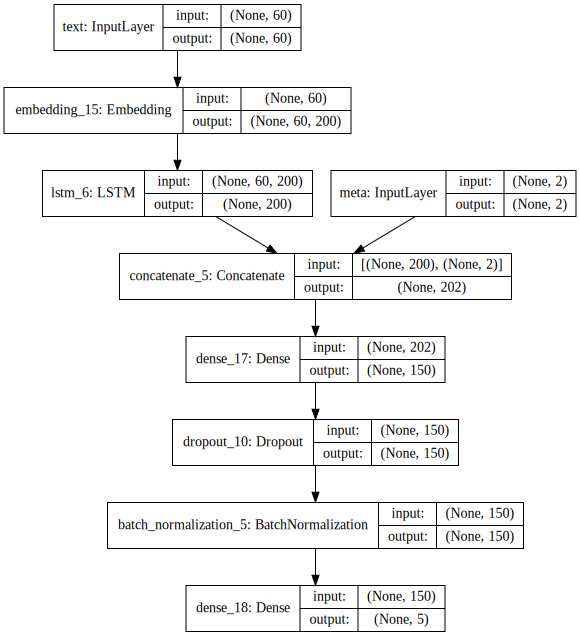

In [0]:
from keras.models import Model
from keras.layers import Dense ,LSTM,concatenate,Input,Flatten,BatchNormalization, GRU

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(2,), name = 'meta')
x=(Embedding(top_words,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))(text_data)
x2 = ((LSTM(200, dropout=0.2, recurrent_dropout=0.2)))(x)
x4 = concatenate([x2, meta_data])
x5 = Dense(150, activation='relu')(x4)
x6 = Dropout(0.25)(x5)
x7 = BatchNormalization()(x6)
out=(Dense(len(set(y)), activation="softmax"))(x7)
model = Model(inputs=[text_data, meta_data ], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

In [0]:
from google.colab import files
files.download("LSTM_with_info.svg")

We create a panda data frame for train, test and validation. We will add the polarity and subjectivity

In [0]:
from textblob import TextBlob
def polarity_txt(text):
  sys.stdout.write('.')
  sys.stdout.flush()
  return TextBlob(text).sentiment[0]



def subj_txt(text):
  sys.stdout.write('.')
  sys.stdout.flush()
  return  TextBlob(text).sentiment[1]


df_biomedic['polarity'] = df_biomedic['narratives'].apply(polarity_txt)
df_biomedic['subjectivity'] = df_biomedic['narratives'].apply(subj_txt)
# Train
df_train = pd.DataFrame()
df_train["narratives"] = clean_tr
df_train["labels"] = train_label
df_train['polarity'] = df_train['narratives'].apply(polarity_txt)
df_train['subjectivity'] = df_train['narratives'].apply(subj_txt)

# Test
df_test = pd.DataFrame()
df_test["narratives"] = clean_te
df_test["labels"] = test_label
df_test['polarity'] = df_test['narratives'].apply(polarity_txt)
df_test['subjectivity'] = df_test['narratives'].apply(subj_txt)

# Validation
df_val = pd.DataFrame()
df_val["narratives"] = clean_val
df_val["labels"] = val_label
df_val['polarity'] = df_val['narratives'].apply(polarity_txt)
df_val['subjectivity'] = df_val['narratives'].apply(subj_txt)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [0]:
df_train[ ["polarity", "subjectivity"] ]

,polarity,subjectivity
0,0.026837,0.418549
1,0.272727,0.415909
2,0.013971,0.296324
3,0.144274,0.490703
4,0.046667,0.333333
...,...,...
3495,0.050926,0.418298
3496,0.203568,0.442227
3497,-0.026852,0.433333
3498,0.037043,0.435488


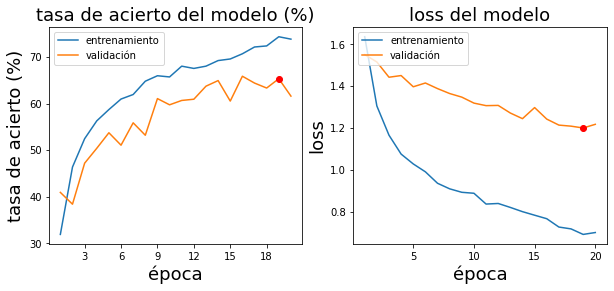

In [0]:
batch_size = 512
nepocas = 20

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [ModelCheckpoint(filepath='simple_LSTM.h5', monitor='val_loss', save_best_only=True)]

for e in range(nepocas):
  h = model.fit([ X_train_seq_pad, df_train[["polarity", "subjectivity"]] ],
                y_train,
                batch_size=batch_size,
                validation_data=([ X_val_seq_pad, df_val[["polarity", "subjectivity"]] ], y_val),
                callbacks=callbacks, # Early stopping
                epochs=1, 
                verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss: # Select the best model in order to loss
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [0]:
model.set_weights(best_weights)
scores = model.evaluate([ X_test_seq_pad, df_test[["polarity", "subjectivity"]] ], y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

750/750 [==============================] - 1s 2ms/step
Accuracy in test: 64.93%


## Simple GRU

<font color="orange"><h1 align="left">
Simple GRU
</h1></font>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 200)          3000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 200)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 200)               240600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total params: 3,242,405
Trainable params: 242,005
Non-trainable params: 3,000,400
_________________________________________________________________
None


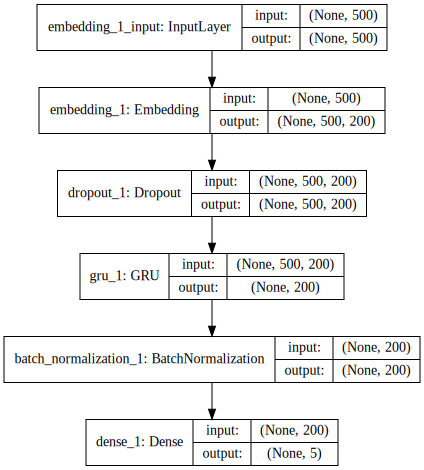

In [0]:
neuron_GRU = 200 # Number of neurones in the hidden layer
neuron_DENSE = len(set(y)) # Number of neurones in output layer = Number of classes
p = 0.2 # Dropout probability

model = Sequential()
model.add(Embedding(top_words, # Vocabulary size
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))
model.add(Dropout(p))
model.add(GRU(neuron_GRU, dropout=p))
model.add(BatchNormalization())
model.add(Dense(neuron_DENSE, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #   metrics=[tf.keras.metrics.CategoricalCrossentropy()])

print(model.summary())
SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

In case you want to load the best embeddings (91% accuracy): 



In [0]:
urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1H7Wor0FCbaebHrOPaHE4-pGJNmot7t3T",
                              "simple_GRU_best.h5") 

simple_GRU_best = "simple_GRU_best.h5"
# load the best saved model
from keras.models import load_model
saved_model = load_model("simple_GRU_best.h5")

scores = saved_model.evaluate(X_test_seq_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

ValueError: ignored

In case you want to train it

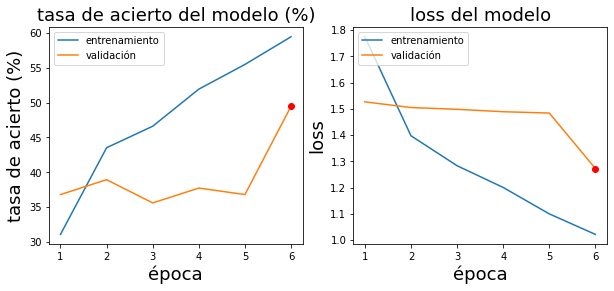

Train on 3500 samples, validate on 750 samples
Epoch 1/1
 512/3500 [===>..........................] - ETA: 1:06 - loss: 0.9457 - accuracy: 0.6055

KeyboardInterrupt: ignored

In [0]:
batch_size = 512
nepocas = 30

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [ModelCheckpoint(filepath='simple_GRU_best.h5', monitor='val_loss', save_best_only=True)]

for e in range(nepocas):
  h = model.fit(X_train_seq_pad, y_train,
                batch_size=batch_size,
                validation_data=(X_val_seq_pad, y_val),
                callbacks=callbacks, # Early stopping
                epochs=1, 
                verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss: # Select the best model in order to loss
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [0]:
model.set_weights(best_weights)
scores = model.evaluate(X_test_seq_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

In [0]:
!ls

clinical_stop_words.txt  precision_medicine	 simple_GRU_best.h5
long_stop_words.txt	 precision_medicine.zip  simple_LSTM.h5
__MACOSX		 sample_data


In [0]:
# For downloading pickle document
from google.colab import files
files.download("simple_GRU_best.h5")

## RNN·: GRU and metadata

<font color="orange"><h1 align="left">Model GRU and concatenate new columns
</h1></font>

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 500, 200)     3000000     text[0][0]                       
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 200)          240600      embedding_2[0][0]                
__________________________________________________________________________________________________
meta (InputLayer)               (None, 2)            0                                            
____________________________________________________________________________________________

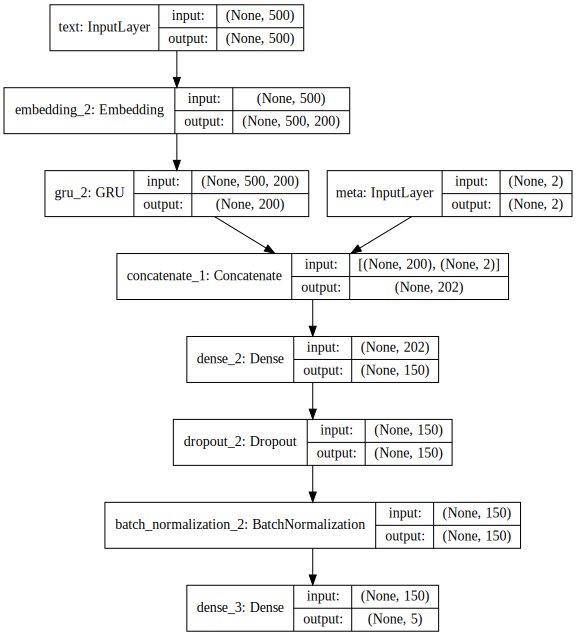

In [0]:
from keras.models import Model
from keras.layers import Dense ,LSTM,concatenate,Input,Flatten,BatchNormalization, GRU

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(2,), name = 'meta')
x=(Embedding(top_words,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))(text_data)
x2 = ((GRU(200, dropout=0.2, recurrent_dropout=0.2)))(x)
x4 = concatenate([x2, meta_data])
x5 = Dense(150, activation='relu')(x4)
x6 = Dropout(0.25)(x5)
x7 = BatchNormalization()(x6)
out=(Dense(len(set(y)), activation="softmax"))(x7)
model = Model(inputs=[text_data, meta_data ], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

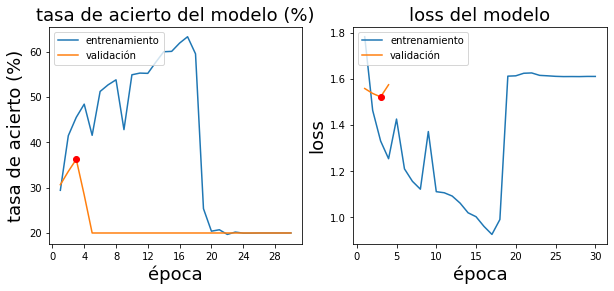

In [0]:
batch_size = 512
nepocas = 30

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [ModelCheckpoint(filepath='simple_LSTM.h5', monitor='val_loss', save_best_only=True)]

for e in range(nepocas):
  h = model.fit([ X_train_seq_pad, df_train[["polarity", "subjectivity"]] ],
                y_train,
                batch_size=batch_size,
                validation_data=([ X_val_seq_pad, df_val[["polarity", "subjectivity"]] ], y_val),
                callbacks=callbacks, # Early stopping
                epochs=1, 
                verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss: # Select the best model in order to loss
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [0]:
model.set_weights(best_weights)
scores = model.evaluate([ X_test_seq_pad, df_test[["polarity", "subjectivity"]] ], y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

750/750 [==============================] - 4s 6ms/step
Accuracy in test: 37.20%


## RNN 5: Bi-GRU

<font color="orange"><h1 align="left">
Model with 2 GRU (Bi-GRU)
</h1></font>

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 200)          3000000   
_________________________________________________________________
gru_7 (GRU)                  (None, 500, 150)          157950    
_________________________________________________________________
gru_8 (GRU)                  (None, 150)               135450    
_________________________________________________________________
batch_normalization_5 (Batch (None, 150)               600       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 755       
Total params: 3,294,755
Trainable params: 294,455
Non-trainable params: 3,000,300
_________________________________________________________________
None


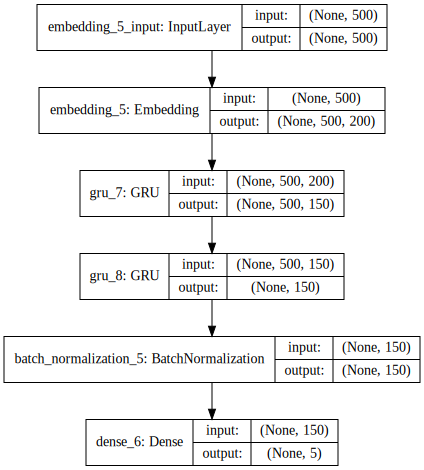

In [0]:
neuron_GRU = 150 # Number of neurones in the hidden layer
neuron_DENSE = len(set(y)) # Number of neurones in output layer = Number of classes
p = 0.2 # Dropout probability

model = Sequential()
model.add(Embedding(top_words, # Vocabulary size
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))
model.add(GRU(150, dropout=p,   return_sequences=True))
model.add(GRU(150, dropout=p))
model.add(BatchNormalization())
model.add(Dense(neuron_DENSE, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #   metrics=[tf.keras.metrics.CategoricalCrossentropy()])

print(model.summary())
SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))



<font color="orange">In case you want to load the best weigths (92.40% accuracy in test):
</h1></font>

This requieres:

* Embedding len = 200

* Max sequence length = 500

* Top words = 15000


In [0]:
urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1Jen0r1UVHYf41o74uDhVoBfjsofVL-PI",
                              "bi_GRU_best_92.h5") 

# load the best saved model
from keras.models import load_model
best_bi_GRU_model = load_model("bi_GRU_best_92.h5")

scores = best_bi_GRU_model.evaluate(X_test_seq_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

750/750 [==============================] - 10s 13ms/step
Accuracy in test: 92.40%


 In case you want to train it

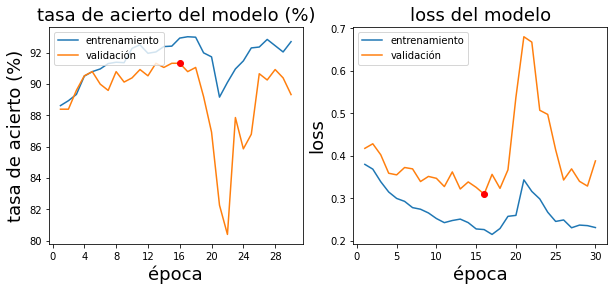

In [0]:
batch_size = 512
nepocas = 30

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [ModelCheckpoint(filepath='simple_GRU_best.h5', monitor='val_loss', save_best_only=True)]

for e in range(nepocas):
  h = model.fit(X_train_seq_pad, y_train,
                batch_size=batch_size,
                validation_data=(X_val_seq_pad, y_val),
                callbacks=callbacks, # Early stopping
                epochs=1, 
                verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss: # Select the best model in order to loss
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [0]:
model.set_weights(best_weights)
scores = model.evaluate(X_test_seq_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

750/750 [==============================] - 9s 12ms/step
Accuracy in test: 92.40%


### Learning visualization

In [0]:
model_aux = Sequential()
model_aux.add(Embedding(top_words, # Vocabulary size
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))
model_aux.add(GRU(150, dropout=p,   return_sequences=True))
model_aux.add(GRU(150, dropout=p, return_sequences=True))
model_aux.add(BatchNormalization())
model_aux.add(Dense(neuron_DENSE, activation='softmax'))
model_aux.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
model_aux.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 200)          3000000   
_________________________________________________________________
gru_11 (GRU)                 (None, 500, 150)          157950    
_________________________________________________________________
gru_12 (GRU)                 (None, 500, 150)          135450    
_________________________________________________________________
batch_normalization_7 (Batch (None, 500, 150)          600       
_________________________________________________________________
dense_8 (Dense)              (None, 500, 5)            755       
Total params: 3,294,755
Trainable params: 294,455
Non-trainable params: 3,000,300
_________________________________________________________________


Label: Breast Cancer  || Text: low dose irradiation promotes proliferation of the human breast cancer mda mb num cells through accumulation of mutant p53 low dose irradiation ldir has been proven to have differential biological effects on normal mammalian somatic cells and cancer cells our previous study showed that p53 gene status is a critical factor regulating the effect of ldir on cancer cells we investigated the effect of ldir on the breast cancer cell line mda mb num that harbors a mutant p53 gene and the normal breast fibroblast cell line hs num bst in the present study we showed that num mgy ldir oov growth of mda mb num cells but not hs num bst cells through cell cycle analyses we found that ldir accelerated cell cycle into s phase in mda mb num cells but did not affect the cell cycle of hs num bst cells using western blotting we demonstrated that the expression of cdk4 cdk6 and cyclin d1 was upregulated in mda mb num cells after ldir although ldir increased ataxia telangiecta

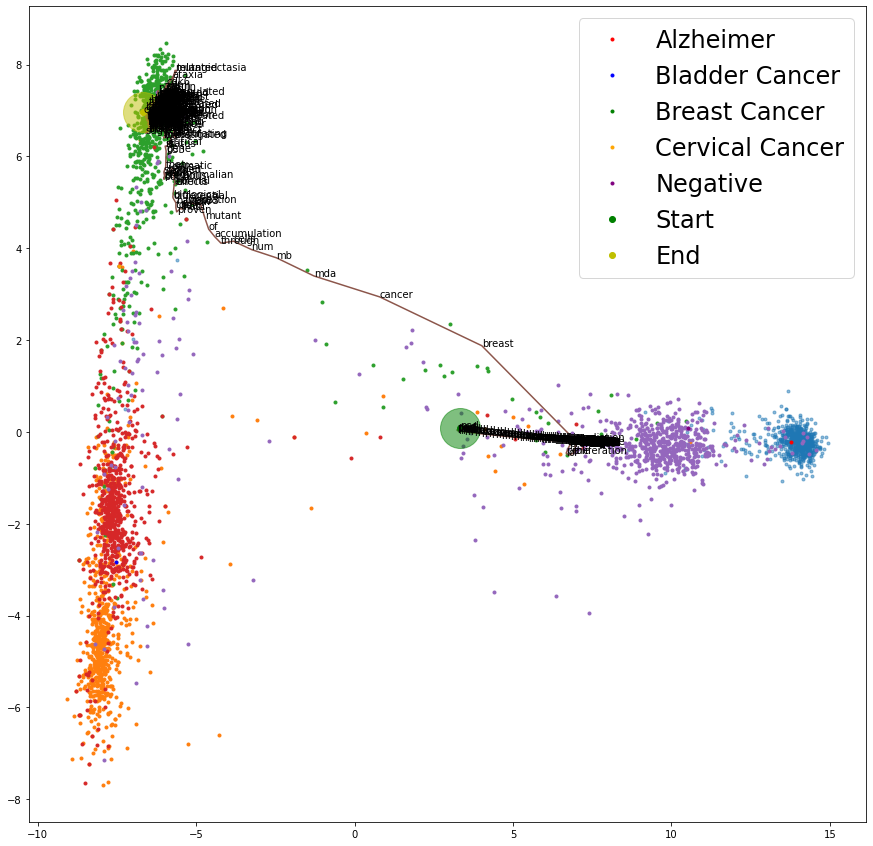

In [94]:
from keras.models import Sequential, load_model, Model

best_weights = best_bi_GRU_model.get_weights().copy()

model_aux.set_weights(best_weights)
model2 = Model(inputs=model_aux.inputs, outputs=model_aux.layers[-2].output)
salidas_LSTM_tr = model2.predict(X_train_seq_pad)
salidas_finales_tr = salidas_LSTM_tr[:,-1,:]

pca = PCA(n_components=2)
pca.fit(salidas_finales_tr)
sals_finales_pca_tr = pca.transform(salidas_finales_tr)

inds_0 = np.where(np.array(train_classes) == 0)[0]
inds_1 = np.where(np.array(train_classes) == 1)[0]
inds_2 = np.where(np.array(train_classes) == 2)[0]
inds_3 = np.where(np.array(train_classes) == 3)[0]
inds_4 = np.where(np.array(train_classes) == 4)[0]



interpretacion_biomedic = {0:"Alzheimer", 1:"Bladder Cancer", 2:"Breast Cancer", 3:"Cervical Cancer", 4:"Negative"}
ejemplo =2320
inds_perm = range(len(X_train_seq_pad[ejemplo])) # no permutar
# inds_perm = np.random.permutation(len(X_train_seq_pad[ejemplo]))
texto = " ".join([int2word[x] for x in np.array(X_train_seq[ejemplo])])
print("Label:", train_label[ejemplo], " || Text:", texto)
visualiza_procesamiento_LSTM(np.array(X_train_seq_pad[ejemplo])[inds_perm], y_train[ejemplo], texto,
                             interpretacion_biomedic, model2, alpha=1)

In [82]:

inds_3

array([   0,   10,   15,   17,   22,   24,   33,   39,   42,   48,   64,
         69,   72,   77,   88,   91,   93,  102,  108,  110,  111,  112,
        116,  117,  119,  124,  125,  132,  179,  189,  191,  197,  202,
        203,  208,  216,  217,  225,  226,  246,  259,  260,  265,  268,
        280,  282,  286,  296,  298,  301,  308,  310,  324,  325,  329,
        332,  335,  339,  342,  343,  344,  348,  350,  355,  358,  378,
        381,  397,  400,  403,  404,  407,  411,  417,  418,  424,  427,
        428,  429,  432,  437,  440,  459,  467,  469,  471,  473,  475,
        480,  484,  490,  491,  496,  503,  504,  505,  525,  528,  534,
        540,  542,  547,  548,  556,  557,  558,  567,  576,  582,  583,
        586,  588,  592,  594,  596,  603,  604,  605,  606,  616,  617,
        618,  626,  630,  636,  637,  641,  654,  655,  664,  671,  675,
        682,  685,  687,  696,  698,  703,  705,  710,  711,  717,  725,
        727,  730,  732,  739,  744,  746,  748,  7

0
Label: Alzheimer  || Text: optimizing neuropsychological assessments for cognitive behavioral and functional impairment classification a machine learning study subjects with alzheimer ' s disease ad show loss of cognitive functions and change in behavioral and functional state affecting the quality of their daily life and that of their families and caregivers a neuropsychological assessment plays a crucial role in detecting such changes from normal conditions however despite the existence of clinical measures that are used to classify and diagnose ad a large amount of subjectivity continues to exist our aim was to assess the potential of machine learning in quantifying this process and optimizing or even reducing the amount of neuropsychological tests used to classify ad patients also at an early stage of impairment we investigated the role of twelve state of the art neuropsychological tests in the automatic classification of subjects with none mild or severe impairment as measured b

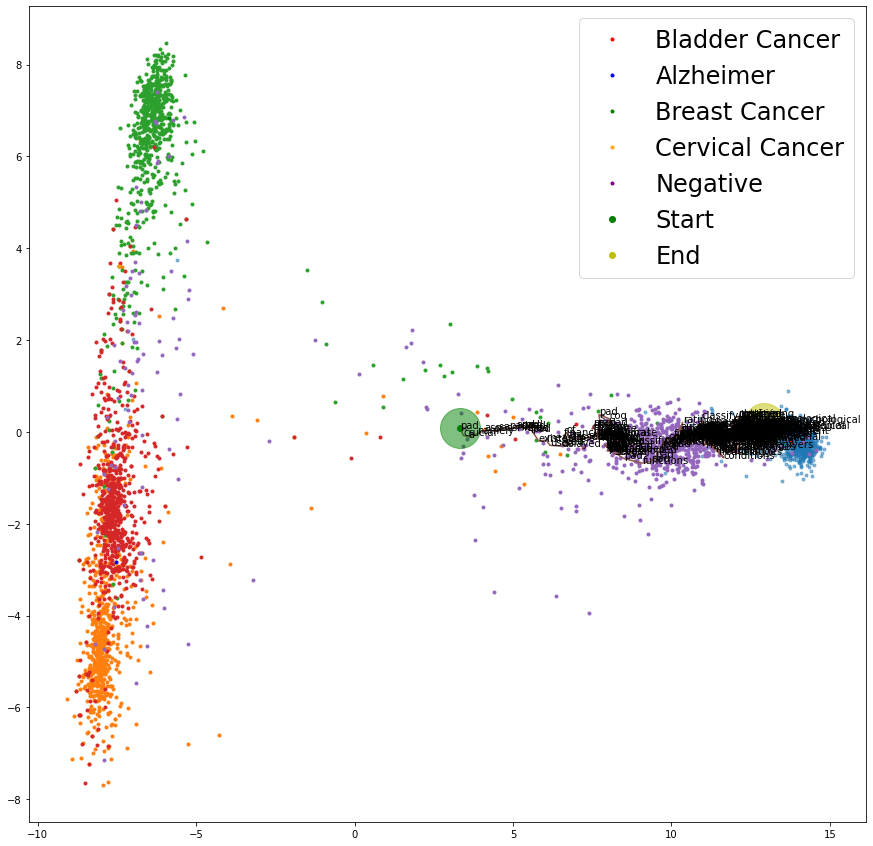

In [93]:
interpretacion_biomedic = {0:"Bladder Cancer", 1:"Alzheimer", 2:"Breast Cancer", 3:"Cervical Cancer", 4:"Negative"}
ejemplo = 6
print(train_classes[ejemplo])
# inds_perm = range(len(X_train_seq_pad[ejemplo])) # no permutar
inds_perm = np.random.permutation(len(X_train_seq_pad[ejemplo]))
texto = " ".join([int2word[x] for x in np.array(X_train_seq[ejemplo])])
print("Label:", train_label[ejemplo], " || Text:", texto)
visualiza_procesamiento_LSTM(np.array(X_train_seq_pad[ejemplo])[inds_perm], y_train[ejemplo], texto,
                             interpretacion_biomedic, model2, alpha=1)

In [0]:
best_weights = best_bi_GRU_model.get_weights().copy()

model_aux.set_weights(best_weights)
model2 = Model(inputs=model_aux.inputs, outputs=model_aux.layers[-2].output)
salidas_LSTM_tr = model2.predict(X_train_seq_pad)
salidas_finales_tr = salidas_LSTM_tr[:,-1,:]

IndexError: ignored

## RNN 4: Bi-LSTM

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 200)          1200000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 250, 128)          168448    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 1,501,189
Trainable params: 300,933
Non-trainable params: 1,200,256
_________________________________________________________________
None


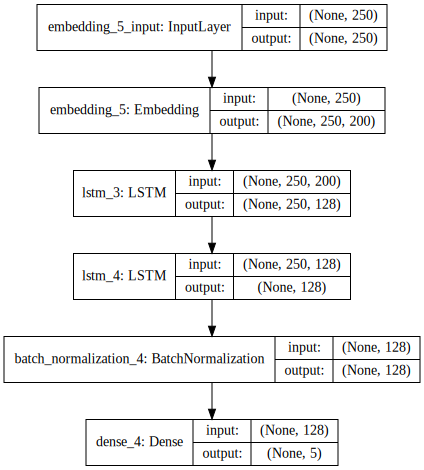

In [0]:
neuron_LSTM = 128 # Number of neurones in the hidden layer
neuron_DENSE = len(set(y)) # Number of neurones in output layer = Number of classes
p = 0.2 # Dropout probability

model = Sequential()
model.add(Embedding(top_words, # Vocabulary size
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))
model.add(LSTM(neuron_LSTM, dropout=p,   return_sequences=True))
model.add(LSTM(neuron_LSTM, dropout=p))
model.add(BatchNormalization())
model.add(Dense(neuron_DENSE, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #   metrics=[tf.keras.metrics.CategoricalCrossentropy()])

print(model.summary())
SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

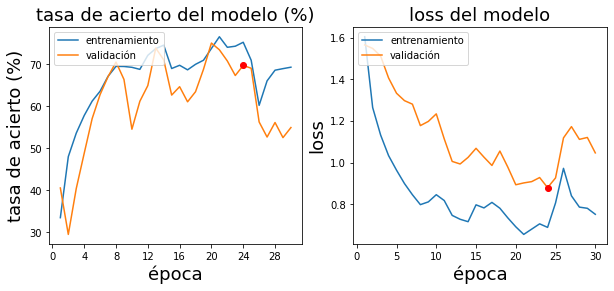

In [0]:
batch_size = 512
nepocas = 30

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [ModelCheckpoint(filepath='simple_GRU_best.h5', monitor='val_loss', save_best_only=True)]

for e in range(nepocas):
  h = model.fit(X_train_seq_pad, y_train,
                batch_size=batch_size,
                validation_data=(X_val_seq_pad, y_val),
                callbacks=callbacks, # Early stopping
                epochs=1, 
                verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss: # Select the best model in order to loss
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [0]:
model.set_weights(best_weights)
scores = model.evaluate(X_test_seq_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

750/750 [==============================] - 5s 6ms/step
Accuracy in test: 72.93%
